In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pandas_datareader as pdr
import pandas_market_calendars as mcal
import datetime
from scipy import stats
from statsmodels.tsa.stattools import coint

In [90]:
# Date and Time
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=365)
nyse = mcal.get_calendar('NYSE')
valid_dates = nyse.valid_days(start_date=start_date, end_date =end_date)
valid_start_day = valid_dates[0].date()
valid_end_day = valid_dates[-1].date()

SMH_top_10_tickers = ['NVDA', 'TSM', 'AVGO', 'TXN', 'AMD', 'ASML', 'ADI','AMAT','QCOM','KLAC'] #Tech-sector

# Download data
df = yf.download(SMH_top_10_tickers, start=valid_start_day)['Adj Close']
df = df.dropna(axis=1, how='any')

[*********************100%%**********************]  10 of 10 completed


In [92]:
# Split data
def Log_return(df): # We use log return as the time series instead of the stock itself (got more nicer properties!)
    return np.log(df/df.shift(1)).dropna()
TT_split = 0.98 #you need constant update so Train-test split must be large to see good result

Train_df = df[:int(len(df)*TT_split)]
Train_df_return = Log_return(Train_df)

Test_df = df[int(len(df)*TT_split):]

In [94]:
def find_cointegrated_pairs(df):
    n = df.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = df.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = df[keys[i]]
            S2 = df[keys[j]]
            result = coint(S1, S2) # return: Test Statistic, P-value, Critical Values
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.01:
                pairs.append([keys[i], keys[j]])
    return score_matrix, pvalue_matrix, pairs

def calculate_spread_zscore(pair, df, window):
    stock1 = df[pair[0]]
    stock2 = df[pair[1]]
    spread = stock1 - stock2
    zscore = (spread - spread.rolling(window=window).mean()) / spread.rolling(window=window).std()
    return zscore

In [96]:
# Calculate rolling z
z_score_window = 20

# Find cointegrated pairs
score_matrix, pvalue_matrix, cointegrated_pairs = find_cointegrated_pairs(Train_df_return)

print(f"Found {len(cointegrated_pairs)} cointegrated pairs:")

Found 45 cointegrated pairs:


In [97]:
def backtest(df,TT_split,pairs,z_score_window,z_entry,z_exit):
    Train_len = int(len(df)*(TT_split))
    Test_position = pd.DataFrame().reindex_like(df[Train_len:])
    Test_position[:] = 0
    Transaction_cost = 2 #USD per transaction
    
    for i, pair in enumerate(pairs):
        zscores = calculate_spread_zscore(pair,df,z_score_window)[Train_len:]
        assert len(zscores) == len(df)-Train_len #For debug
        position = 0
        
        for j in range(len(zscores)):
            j_adj = Train_len + j #trasnlate j into df loction
            assert df.index[j_adj] == Test_position.index[j] #Make sure we are looking at the same day
            if position == 0:
                if zscores.iloc[j] > z_entry: # Short the spread: Sell S1 buy S2
                    position = -1
                    Test_position[pair[0]].iloc[j] += df[pair[0]].iloc[j_adj] - Transaction_cost #sell = gain money
                    Test_position[pair[1]].iloc[j] -= df[pair[1]].iloc[j_adj] - Transaction_cost #buy = use money
                elif zscores.iloc[j] < -z_entry: # Long the spread: Buy S1 sell S2
                    position = 1
                    Test_position[pair[0]].iloc[j] -= df[pair[0]].iloc[j_adj] - Transaction_cost
                    Test_position[pair[1]].iloc[j] += df[pair[1]].iloc[j_adj] - Transaction_cost
                    
            elif position == -1:
                if zscores.iloc[j] < z_exit: # Exit short position: Buy back S1 and sell all S2
                    position = 0
                    Test_position[pair[0]].iloc[j] -= df[pair[0]].iloc[j_adj] - Transaction_cost
                    Test_position[pair[1]].iloc[j] += df[pair[1]].iloc[j_adj] - Transaction_cost
                    
            elif position == 1:
                if zscores.iloc[j] > -z_exit: # Exit long position: Sell all S1 and Buy back S2
                    position = 0
                    Test_position[pair[0]].iloc[j] += df[pair[0]].iloc[j_adj] - Transaction_cost
                    Test_position[pair[1]].iloc[j] -= df[pair[1]].iloc[j_adj] - Transaction_cost
                    
    return Test_position  
T_run = backtest(df,TT_split,cointegrated_pairs,z_score_window,2,0)

<Axes: title={'center': 'Portfolio worth'}, xlabel='Date', ylabel='USD'>

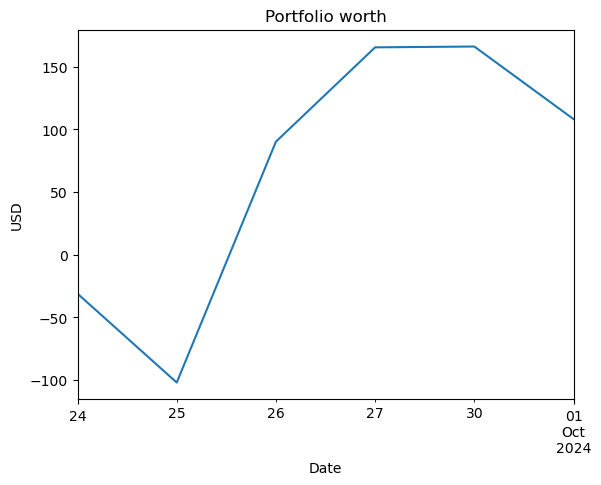

In [100]:
Portfolio = T_run.sum(axis=1).cumsum()
Portfolio.plot(ylabel='USD',title='Portfolio worth',label="Total")

In [102]:
Profit_final = Portfolio.iloc[-1]
max_risk = min(Portfolio)
print(f"Final profit is {Profit_final:.2f} USD")
print(f"Max risk is {max_risk:.2f} USD")
print(f'Profit to risk ratio: {Profit_final/max_risk:.2f}')

Final profit is 108.24 USD
Max risk is -101.93 USD
Profit to risk ratio: -1.06
